Locate_1(children=(VBox(children=(HBox(children=(IntSlider(value=150, description='P-arrival', max=1200), IntS…

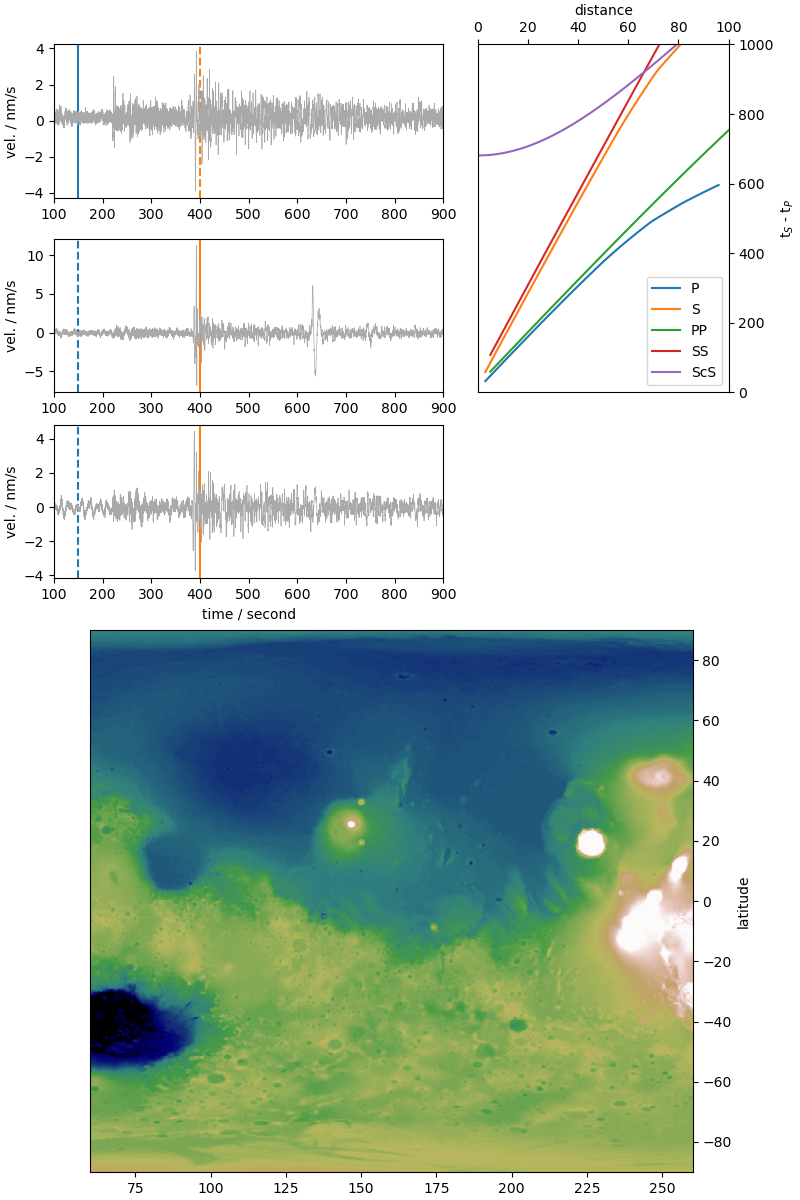

In [1]:
%matplotlib widget

from helpers.locate_1 import Locate_1

Locate_1()